# MNISTデータの用意
手書きの数字の白黒画像（0から9まで）で構成された古典的なデータセットである、MNISTデータセットを使用します。
ファイルのパスを扱うために、pathlib（Python 3標準ライブラリの一部）を使用し、requestsを用いてデータセットをダウンロードします。

In [32]:
%matplotlib inline

In [33]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

このデータセットはNumpy配列と同じ形式であり、データを連結して格納するためにPickleを利用しています。

In [34]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

それぞれの画像のサイズは 28 x 28 ですが、1次元に平坦化されて要素数が784 (= 28×28)の数値配列として保存されています。
まずデータを2次元の画像に変換し、画面に表示してみましょう。

4
(50000, 784)


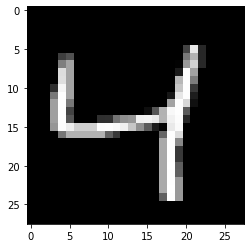

In [35]:
from matplotlib import pyplot
import numpy as np

idx = 2
pyplot.imshow(x_train[idx].reshape((28, 28)), cmap="gray")
print(y_train[idx])
print(x_train.shape)
# print(type(x_train[idx][0]))
# print(x_train[idx])

PyTorchはNumpy配列ではなくtorch.tensorを利用するので、データを変換する必要があります。

In [37]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# (torch.nnなしで）ニューラルネットワークを構築
まず、PyTorch Tensorによる演算以外は何も利用せずに、ニューラルネットワークのモデルを実装してみましょう。
### 注釈
重みの初期化はXavierの初期値(1/sqrt(n)を掛ける)を使用しています。

In [38]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

それでは、シンプルな線形モデルを作成するために、単純な行列の乗算とブロードキャストを使った加算を定義してみましょう。
さらに、活性化関数も必要になるので、log_softmax関数を定義して使用します。

In [39]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

上記のコードで、@は行列積を表しています。
一つのバッチデータ（この場合は64枚の画像）に対して、各関数が実行されることになります。

以下のコードは、順伝播の経路を表していますが、乱数で定義された重みをそのまま使用しているので、予測値はランダムな結果よりも優れたものは得られないことに注意してください。

In [40]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2363, -2.5043, -2.5111, -2.4225, -2.4171, -2.3085, -2.1428, -2.3620,
        -2.4217, -1.8798], grad_fn=<SelectBackward>) torch.Size([64, 10])


このようにTensor変数predsには、値だけではなく勾配情報も含まれていて、誤差逆伝播を行う際に利用することができます。

損失関数として、負の対数尤度を出力する関数（nll関数）を実装してみましょう（ここでも標準的なPythonのコードを用います）。

In [41]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

先ほど実装したランダムなモデルで損失の値を確認してみましょう。

モデルが改善されていることは、誤差逆伝播を行った後に確認することができます。

In [42]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3015, grad_fn=<NegBackward>)


モデルの予測精度を計算する関数も実装しておきましょう。
それぞれの予測において、出力が最大となった要素のラベルが正解のラベルと一致すれば、予測が正しかったことになります。
（日本語訳注）：0から9までの手書き文字を予測する場合、モデルから出力されるTensorは10種類の値を持ち、それぞれの値は数字の0から順に対応付けられています。

In [44]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

ランダムなモデルの精度を確認して、損失が減少すると予測精度が改善されるのか確認してみます。

In [45]:
print(accuracy(preds, yb))

tensor(0.0625)


これで、学習を繰り返し行う準備が整いました。
それでは次に、イテレーションごとに次の手順を実施します。
- データのミニバッチをbs（バッチサイズ）の大きさで選択する
- モデルを用いて予測を行う
- 損失を計算する
- loss.backward()はモデルの勾配を更新します。この場合では重みとバイアスの勾配を算出しています。

In [46]:
from IPython.core.debugger import set_trace

lr = 0.05  # learning rate
epochs = 10  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

これで、最小限の大きさのニューラルネットワークをスクラッチで実装し訓練することに成功しました（このケースでは、隠れ層がないので単なるロジスティクス回帰になります）。

では、モデルの損失と精度を算出して、その前に得た結果と比較してみましょう。

In [47]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3719, grad_fn=<NegBackward>) tensor(0.8750)
